# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# !pip install -q kaggle

In [3]:
# !mkdir ~/.kaggle

In [4]:
# !cp kaggle.json ~/.kaggle/

In [5]:
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces

100% 3.75G/3.75G [03:19<00:00, 20.1MB/s]
100% 3.75G/3.75G [03:19<00:00, 20.2MB/s]


In [7]:
# ! unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34905.jpg  
  inflating: real_v

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [11]:
train = pd.read_csv("/content/real_vs_fake/train.csv")
valid = pd.read_csv("/content/real_vs_fake/valid.csv")
test  = pd.read_csv("/content/real_vs_fake/test.csv")

Reducing the data

In [12]:
def random_n_images(df,no_imgs=10000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

train_subset = random_n_images(train,no_imgs=10000,shuffle=True)
valid_subset = random_n_images(valid,no_imgs=2000,shuffle=False)
test_subset = random_n_images(test,no_imgs=2000,shuffle=False)

Converting to tensors

In [13]:
BATCH_SIZE = 32
image_height = 256
image_width = 256

In [16]:
train_tfds = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_tfds = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_tfds = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augument(image, label):
    return image, label

train_tfds = train_tfds.map(read_image).map(augument).batch(BATCH_SIZE)
valid_tfds = valid_tfds.map(read_image).map(augument).batch(1).prefetch(1)
test_tfds = test_tfds.map(read_image).map(augument).batch(1)

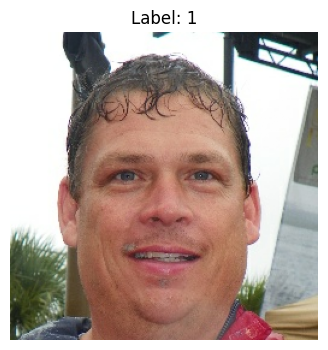

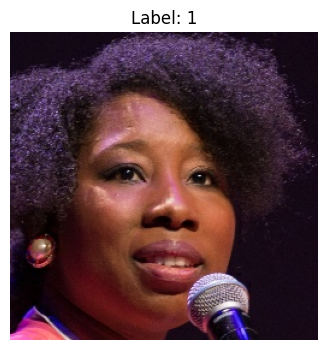

In [17]:
for images, labels in train_tfds.take(1):  # Adjust the number of batches as needed
    for i in range(2):
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i, :, :, :].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

## Convolutional neural network

In [18]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet_clf = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 5s 0us/step


In [21]:
save_callback = ModelCheckpoint('/content/gdrive/MyDrive/GAN_research/resnet_clf_cp.h5'
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='val_loss'
#                                         ,patience=5)

resnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])
# resnet_clf.summary()

In [22]:
tf.keras.backend.clear_session()
resnet_clf_history = resnet_clf.fit(
    train_tfds,
    epochs=10,
    validation_data=valid_tfds,
    callbacks=[save_callback],
    use_multiprocessing=True
)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.7989

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 235s 595ms/step - loss: 0.4431 - accuracy: 0.7989 - val_loss: 0.7058 - val_accuracy: 0.4970
Epoch 2/10
313/313 [==============================] - 155s 495ms/step - loss: 0.2208 - accuracy: 0.9074 - val_loss: 1.8430 - val_accuracy: 0.5000
Epoch 3/10
313/313 [==============================] - 164s 522ms/step - loss: 0.1433 - accuracy: 0.9437 - val_loss: 0.4196 - val_accuracy: 0.8080
Epoch 4/10
313/313 [==============================] - 155s 495ms/step - loss: 0.1085 - accuracy: 0.9573 - val_loss: 0.6264 - val_accuracy: 0.7695
Epoch 5/10
313/313 [==============================] - 161s 513ms/step - loss: 0.0784 - accuracy: 0.9712 - val_loss: 0.3069 - val_accuracy: 0.8815
Epoch 6/10
313/313 [==============================] - 155s 494ms/step - loss: 0.0701 - accuracy: 0.9728 - val_loss: 0.6022 - val_accuracy: 0.8110
Epoch 7/10
313/313 [==============================] - 155s 494ms/step - loss: 0.0517 - accuracy: 0.9804 - val_loss: 0.3241 - val_accura

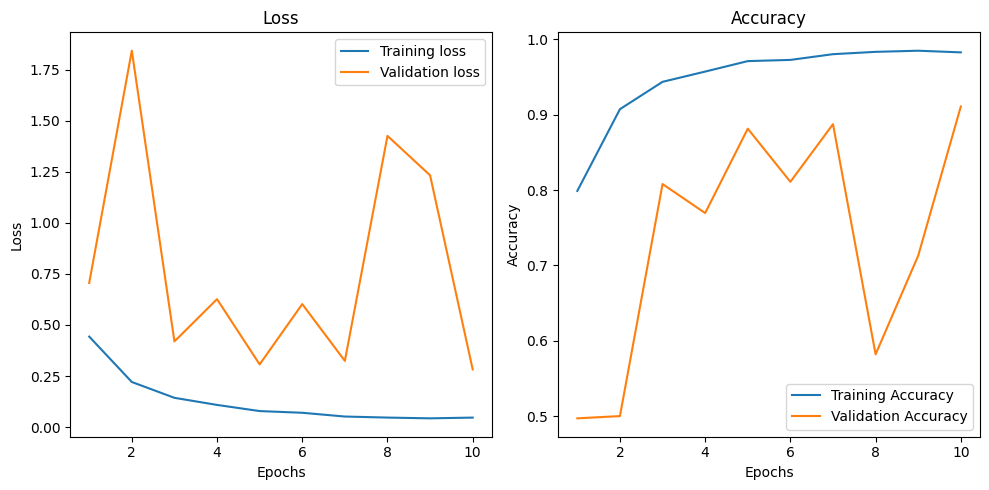

In [23]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Testing set
resnet_clf.evaluate(test_tfds)

2000/2000 [==============================] - 25s 12ms/step - loss: 0.2742 - accuracy: 0.9155


[0.2742463946342468, 0.9154999852180481]

In [25]:
# Saving model
from datetime import datetime
filename = "/content/gdrive/MyDrive/GAN_research/resnet_clf.h5"
tf.keras.models.save_model(resnet_clf, filename)

<ipython-input-25-dbe07faa2582>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(resnet_clf, filename)


Manual testing

In [26]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

1/1 [==============================] - 1s 1s/step
[[0.]]


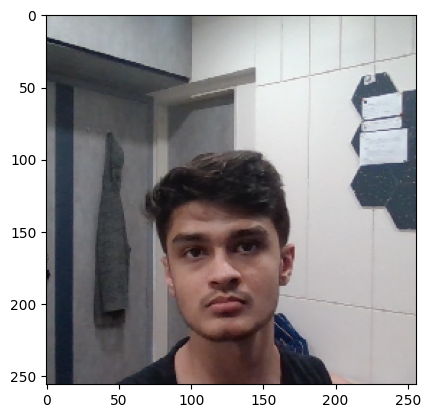

In [27]:
# Real image
img_path = "Real.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

1/1 [==============================] - 0s 36ms/step
[[0.]]


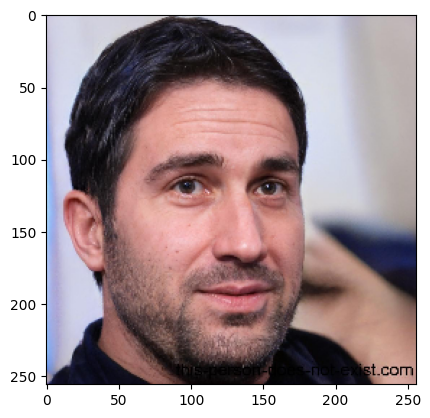

In [28]:
# Fake image(hard)
img_path = "Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

1/1 [==============================] - 0s 61ms/step
[[0.]]


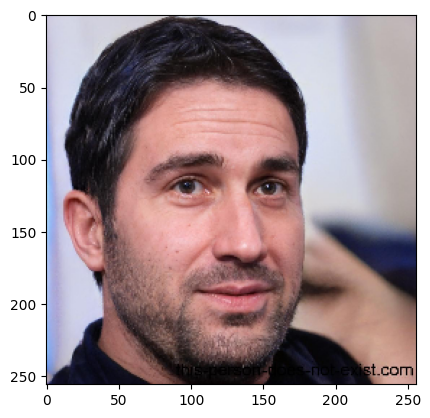

In [29]:
# Fake image(hard)
img_path = "Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

1/1 [==============================] - 0s 23ms/step
[[0.]]


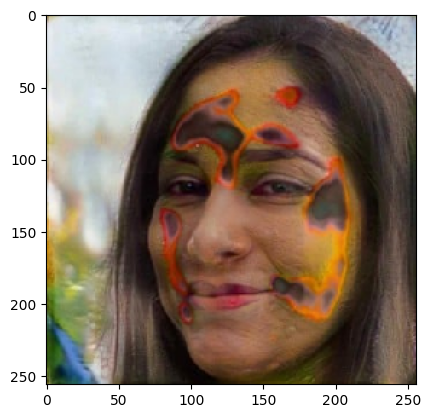

In [30]:
# Fake image(easy)
img_path = "Easy.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

## Loading the best model so far

In [31]:
from keras.models import load_model
model = load_model("/content/gdrive/MyDrive/GAN_research/resnet_clf_cp.h5")
model.evaluate(test_tfds)

2000/2000 [==============================] - 25s 12ms/step - loss: 0.2742 - accuracy: 0.9155


[0.2742463946342468, 0.9154999852180481]

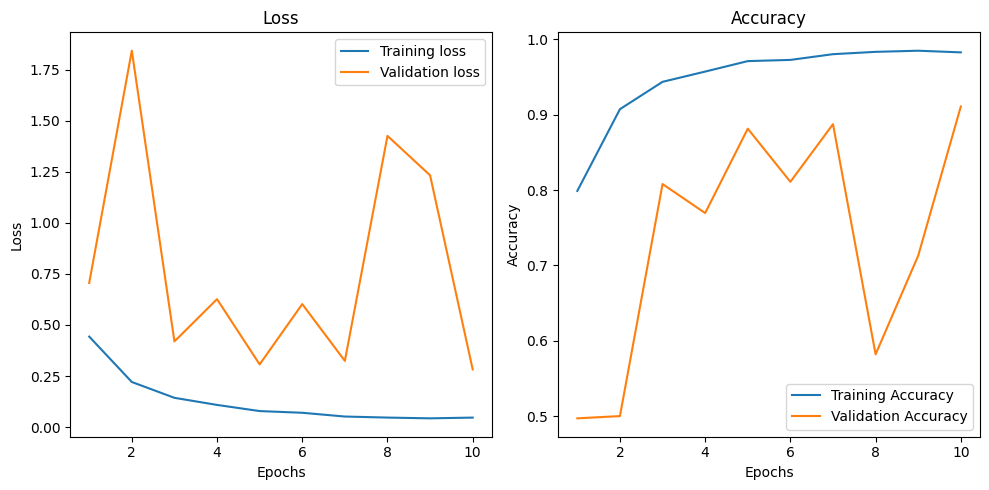

In [32]:
# Visualizing results
# training_loss = resnet_clf_history.history['loss']
# validation_loss = resnet_clf_history.history['val_loss']
# training_accuracy = resnet_clf_history.history['accuracy']
# validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()